In [1]:
from __future__ import annotations

import ast
import typing as T
import collections.abc as C
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def load_dataset(filepath: str) -> pd.DataFrame:
    def parse_values(x: pd.Series) -> pd.Series:
        keys = ast.literal_eval(x.loc["keys"])[0]
        values = (
            float(x) if x != "null" else pd.NA
            for x in ast.literal_eval(x.loc["values"])[0]
        )
        return pd.Series(dict(zip(keys, values)))

    df = pd.read_csv(filepath, parse_dates=[2], index_col=0)
    values = df.apply(parse_values, axis=1)
    df = pd.concat([df[["configuration_item_id", "ts"]], values], axis=1)
    return df.convert_dtypes()

In [3]:
train_dataset = load_dataset("data/train999.csv")
test_dataset = load_dataset("data/test999.csv")

In [4]:
assert list(train_dataset.columns) == list(test_dataset.columns)
meteo_cols = [
    str(col) for col in train_dataset.columns if str(col).startswith("meteo_")
]
meteo_cols

['meteo_layer_type',
 'meteo_cloudiness',
 'meteo_wind_velocity',
 'meteo_humidity',
 'meteo_t_underroad',
 'meteo_freezing_point',
 'meteo_wind_direction',
 'meteo_dew_point',
 'meteo_t_road',
 'meteo_wind_gusts',
 'meteo_t_air',
 'meteo_air_pressure']

In [5]:
train_stations = dict(list(train_dataset.groupby("configuration_item_id")))
test_stations = dict(list(test_dataset.groupby("configuration_item_id")))

assert train_stations.keys() == test_stations.keys()
stations = list(train_stations.keys())
stations

[24445, 30928]

In [6]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    scaled = StandardScaler().fit_transform(df)
    return pd.DataFrame(scaled, index=df.index)

In [21]:
def detect_anomalies(st_train: pd.DataFrame, st_test: pd.DataFrame, *, thresh = 5):
    X_train = st_train[meteo_cols]
    X_test = st_test[meteo_cols]

    na_result = X_test[X_test.isna().any(axis=1)].copy()
    na_result["cluster"] = na_result.isna().any(axis=1).astype(int)

    X_train = X_train.dropna()
    X_test = X_test.dropna()

    clf = AutoEncoder(hidden_neuron_list=[3, 3])
    clf.fit(X_train)

    y_test_scores = pd.Series(clf.decision_function(X_test))
    y_test_scores.hist(bins="auto", figsize=(10, 4))

    df_test = X_test.copy()
    df_test = df_test.assign(score=y_test_scores.values)
    df_test = df_test.assign(cluster=np.where(df_test['score'] < thresh, 0, 1))

    result = pd.concat([X_test.assign(cluster=df_test["cluster"].values), na_result])
    
    return result

In [22]:
def extrapolate_naive(df: pd.DataFrame):
    """Use cluster as anomaly value for all columns."""
    result = df.copy()
    anomaly_cols = [f"anomaly_{col}" for col in meteo_cols]
    for col in anomaly_cols:
        result[col] = result["cluster"]
    return result

In [23]:
def extrapolate_with_neighbors(df: pd.DataFrame):
    """Mark all (scaled) cells that are at least 1 greater or less than either neighbor. Needs `ts` column."""
    result = df.set_index("ts").sort_index()
    for col in meteo_cols:
        result[f"anomaly_{col}"] = result[col].diff().shift(-1).abs().gt(1)
        result[f"anomaly_{col}"] |= result[col].diff().shift(1).abs().gt(1)
        result[f"anomaly_{col}"] &= result["cluster"] == 1
        result[f"anomaly_{col}"] = result[f"anomaly_{col}"].fillna(False).astype(int)
    return result

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure,cluster,ts,id
id,,,,,,,,,,,,,,,
2313,1.0,3,3.8,35.1,34.5,0.0,164,-13.6,40.4,5.7,0.0,749,0,2024-06-11 06:30:01,2313
2274,1.0,3,0.6,84.2,26.2,0.0,282,-2.3,24.2,2.4,0.0,748,0,2024-06-10 02:00:01,2274
2240,1.0,2,0.4,55.1,32.7,0.0,282,-7.9,30.2,1.1,0.0,745,0,2024-06-08 17:30:00,2240
2626,1.0,2,2.4,75.7,30.5,0.0,23,-3.8,34.4,4.7,0.0,742,0,2024-06-24 11:30:00,2626
2134,1.0,3,4.8,30.1,38.5,0.0,283,-15.5,38.9,8.3,0.0,747,0,2024-06-03 14:00:02,2134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,<NA>,2,4.7,81.5,21.8,<NA>,310,11.7,18.4,7.7,14.9,735,1,2024-06-09 03:00:01,802
361,<NA>,2,1.6,71.4,20.7,<NA>,205,11.4,19.3,3.4,16.6,734,1,2024-05-26 11:30:01,361
1583,<NA>,7,0.0,100.0,23.8,<NA>,166,16.0,23.8,0.0,16.0,737,1,2024-06-26 21:00:02,1583


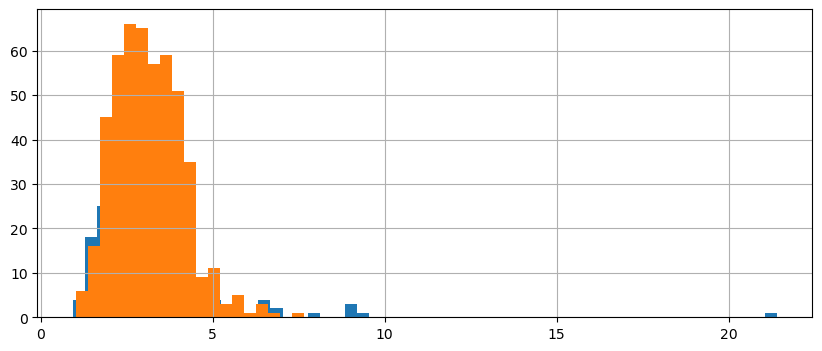

In [24]:
results = []
for station in stations:
    st_train = train_stations[station]
    st_test = test_stations[station]
    res = detect_anomalies(st_train, st_test)
    results.append(res)
result = pd.concat(results).join(test_dataset['ts'])

result["id"] = result.index
result

In [25]:
# result = extrapolate_naive(result)
result = extrapolate_with_neighbors(result)

result["ts"] = result.index
result = result.set_index("id").reindex(test_dataset.index)

anomaly_cols = [f"anomaly_{col}" for col in meteo_cols]
result["target"] = result[anomaly_cols].agg(lambda x: "[%s]" % ", ".join(map(str, x)), axis=1)
result["target"].value_counts()

target
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    754
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]     17
[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]     14
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]      4
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]      4
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]      2
[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]      2
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]      2
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]      2
[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]      2
[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]      2
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]      2
[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]      2
[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]      2
[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]      1
[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]      1
[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]      1
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]      1
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]      1
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]      1
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]      1
[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]      1
[0, 1, 0, 1, 1, 0, 1, 0, 

In [26]:
result['target'].to_csv("out/autoenc/autoenc-neigh-3.csv")

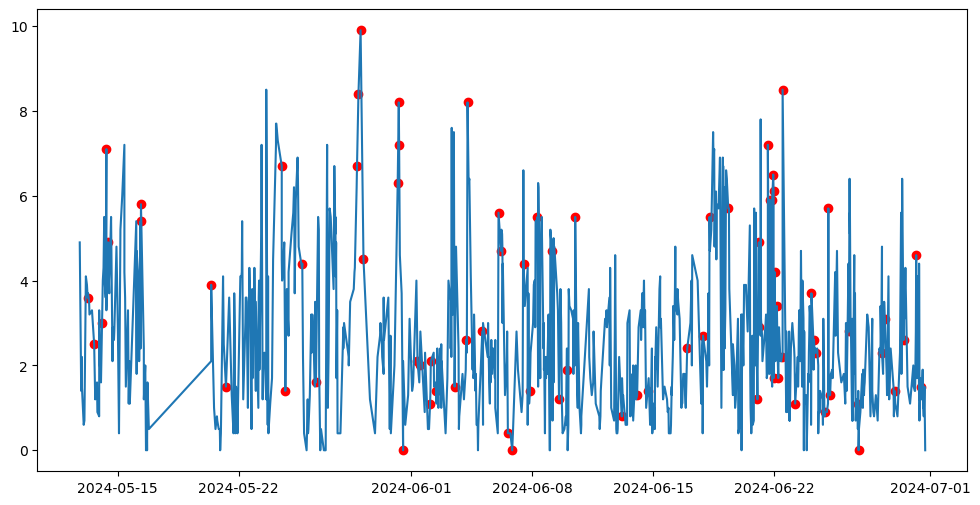

In [27]:
ap = result.set_index("ts").sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
a = ap.loc[ap["cluster"] == 1, ["meteo_wind_velocity"]]
ax.plot(ap.index, ap["meteo_wind_velocity"])
ax.scatter(a.index, a["meteo_wind_velocity"], color="red")